In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
!unzip -o cats_and_dogs.zip


!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 25
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.657.jpg  
  inflating: cats_and_dogs/train/dogs/dog.131.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.131.jpg  
  inflating: cats_and_dogs/train/dogs/dog.119.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.119.jpg  
  inflating: cats_and_dogs/train/dogs/dog.74.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.74.jpg  
  inflating: cats_and_dogs/train/dogs/dog.60.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_do

In [3]:
# 3

# Масштабуємо значення пікселів (rescale=1./255)
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Генератор навчальних даних
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# Генератор валідаційних даних
val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# Оскільки в test/ немає підкаталогів ("cats", "dogs"), треба трохи хитрощів:
# Створимо тимчасову директорію з однією загальною міткою (наприклад, "test")

import shutil
import os

# Створюємо тимчасову структуру, якщо ще не існує
test_dir_fixed = os.path.join(PATH, 'test_fixed')
if not os.path.exists(test_dir_fixed):
    os.makedirs(os.path.join(test_dir_fixed, 'unknown'))
    for fname in os.listdir(test_dir):
        src = os.path.join(test_dir, fname)
        dst = os.path.join(test_dir_fixed, 'unknown', fname)
        shutil.copyfile(src, dst)

# Генератор тестових даних
test_data_gen = test_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=test_dir_fixed,
    shuffle=False,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None  # без міток, бо будемо передбачати
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


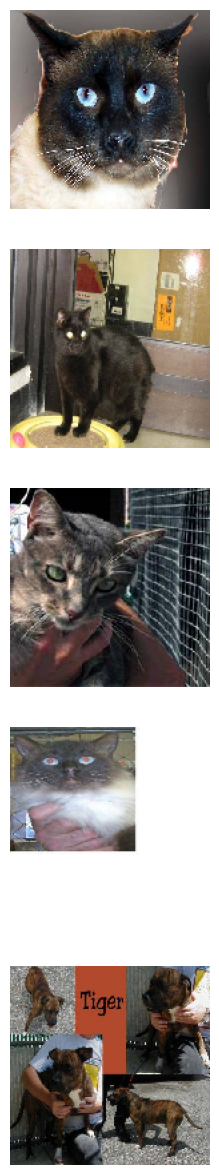

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [5]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1./255,               # Масштабування пікселів
    rotation_range=40,            # Випадкове обертання зображень (до 40 градусів)
    width_shift_range=0.2,        # Горизонтальний зсув
    height_shift_range=0.2,       # Вертикальний зсув
    shear_range=0.2,              # Зсув (shear)
    zoom_range=0.2,               # Масштабування
    horizontal_flip=True,         # Горизонтальне віддзеркалення
    fill_mode='nearest'           # Заповнення пікселів після трансформацій
)

Found 2000 images belonging to 2 classes.


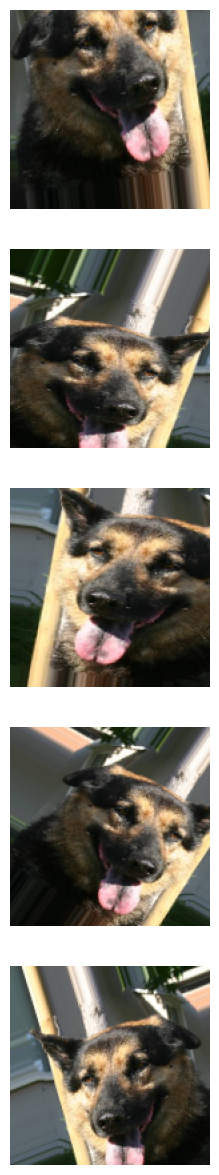

In [6]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [7]:
# 7
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Для зменшення перенавчання
    Dense(1, activation='sigmoid')  # 1 вихід для задачі binary classification
])

# Компіляція моделі
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Виведення архітектури
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 8
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5260 - loss: 0.9941 - val_accuracy: 0.5022 - val_loss: 0.6923
Epoch 2/25
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4844 - loss: 0.6963

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.4844 - loss: 0.6963 - val_accuracy: 0.5089 - val_loss: 0.6916
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5048 - loss: 0.6931 - val_accuracy: 0.5067 - val_loss: 0.6896
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.5469 - loss: 0.6907 - val_accuracy: 0.5134 - val_loss: 0.6898
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5395 - loss: 0.6904 - val_accuracy: 0.5480 - val_loss: 0.6888
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.5000 - loss: 0.6924 - val_accuracy: 0.5435 - val_loss: 0.6888
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5313 - loss: 0.6883 - val_accuracy: 0.6060 - val_loss: 0.6705
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 0.5938 - loss: 0.6686 - val_accuracy: 0.5692 - val_loss: 0.6667
Epoch 9/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5407 - loss: 0.6792 - val_accuracy: 0.5737 - val_loss: 0.

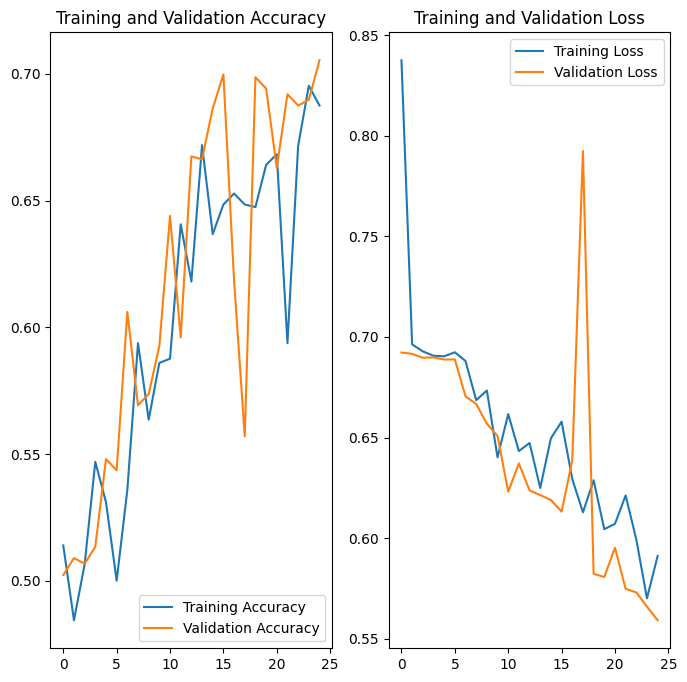

In [9]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 678ms/step


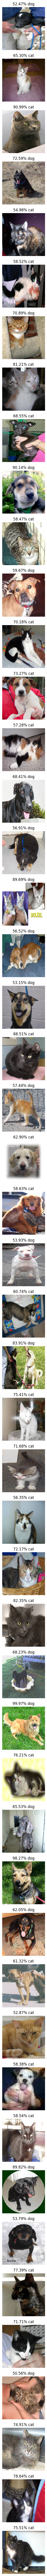

In [10]:
# Отримання зображень з test_data_gen
test_images = next(test_data_gen)  # оскільки shuffle=False, отримуємо в правильному порядку

# Отримання ймовірностей від моделі (вихід sigmoid — від 0 до 1)
predictions = model.predict(test_images)

# Перетворення ймовірностей у зручний формат (список чисел)
probabilities = predictions.flatten()  # перетворення з 2D (n, 1) в 1D масив

# Візуалізація
plotImages(test_images, probabilities)

In [11]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 78.0% of the images of cats and dogs.
You passed the challenge!
